In [1]:
import os

import jax
import jax.numpy as jnp

try:
    from jaxtyping import Array, Float
except ModuleNotFoundError:
    %pip install jaxtyping
    from jaxtyping import Array, Float

import matplotlib.pyplot as plt

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

In [2]:
if False:
    os.environ["LATEXIFY"] = ""
    os.environ["FIG_DIR"] = "./"

/home/patel_zeel/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/home/patel_zeel/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


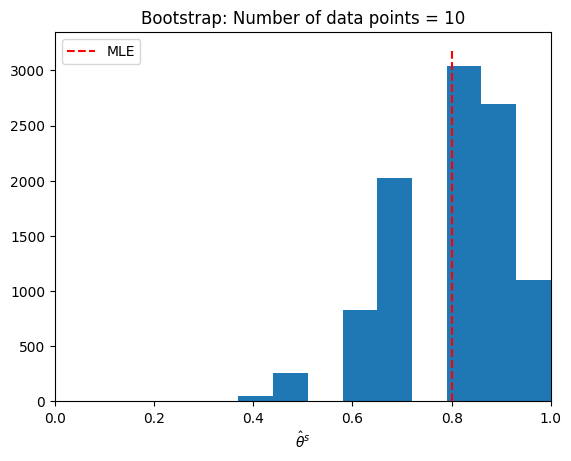

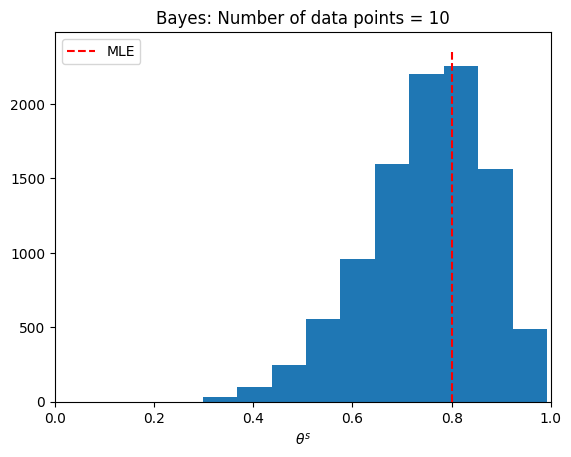

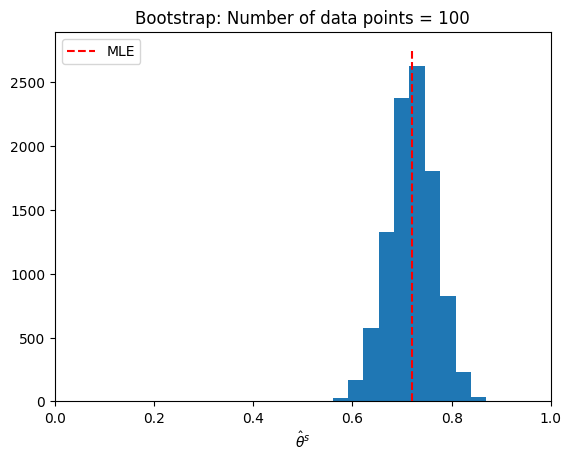

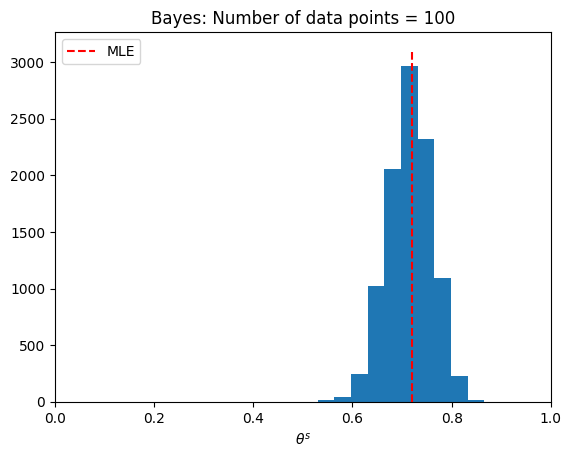

In [3]:
latexify(fig_height=1.85, width_scale_factor=2)
theta = 0.7
choices = [10, 100]
n_bootstrap_draws = 10000
SEED = 0


def mle_fn(x: Float[Array, "n_data_points"]):
    return jnp.mean(x)


for n_data_points in choices:
    # Generate a dataset with true parameters
    data_key = jax.random.PRNGKey(SEED + n_data_points)
    data = jax.random.bernoulli(data_key, p=theta, shape=(n_data_points,))

    # Calculate MLE of the dataset
    mle = mle_fn(data)

    # Parametric bootstrap
    generative_fn = lambda key: jax.random.bernoulli(key, p=mle, shape=(n_data_points,))
    data_key = jax.random.split(data_key, num=1)[0]
    bootstrap_keys = jax.random.split(data_key, num=n_bootstrap_draws)

    bootstrap_samples = jax.vmap(generative_fn)(bootstrap_keys)
    bootstrap_mle = jax.vmap(mle_fn)(bootstrap_samples)

    plt.figure()
    plt.title(f"Bootstrap: Number of data points = {n_data_points}")
    plt.hist(bootstrap_mle, bins=10)
    plt.vlines(mle, *plt.ylim(), zorder=10, color="r", linestyle="--", label="MLE")
    plt.xlabel(r"$\hat{\theta}^s$")
    plt.xlim(0, 1)
    plt.legend(loc="upper left")
    savefig(f"bootstrap_demo_bootstrap_{n_data_points}")

    # Non-parametric bootstrap
    generative_fn = lambda key: jax.random.choice(key, data, shape=(n_data_points,), replace=True)
    data_key = jax.random.split(data_key, num=1)[0]
    bootstrap_keys = jax.random.split(data_key, num=n_bootstrap_draws)

    bootstrap_samples = jax.vmap(generative_fn)(bootstrap_keys)
    bootstrap_mle = jax.vmap(mle_fn)(bootstrap_samples)

    # Bayesian estimate
    counts_of_1 = jnp.sum(data)
    counts_of_0 = len(data) - counts_of_1
    alpha = 1
    beta = 1
    posterior_alpha = alpha + counts_of_1
    posterior_beta = beta + counts_of_0

    bayes_key = jax.random.split(data_key, 1)[0]
    posterior_samples = jax.random.beta(bayes_key, posterior_alpha, posterior_beta, shape=(n_bootstrap_draws,))

    plt.figure()
    plt.title(f"Bayes: Number of data points = {n_data_points}")
    plt.hist(posterior_samples, bins=10)
    plt.vlines(mle, *plt.ylim(), zorder=10, color="r", linestyle="--", label="MLE")
    plt.xlabel(r"$\theta^s$")
    plt.xlim(0, 1)
    plt.legend(loc="upper left")
    savefig(f"bootstrap_demo_bayes_{n_data_points}")